# Superconducting qubits: improving the performance of single qubit gates
**Increasing robustness against dephasing and control noise using Q-CTRL pulses**
    
BOULDER OPAL enables you to create pulses that achieve a target operation on a given quantum hardware, and that are robust against dephasing and/or control noise. The first section of the notebook presents the various steps necessary to create dephasing-robust pulses and characterize their performance using Q-CTRL tools. The second produces experimental validation of the robust pulses through their implementation on the IBM-Q hardware (note that executing hardware-related cells requires a valid IBM account). The third section goes through the steps described in the previous two sections and presents the design, verification and implementation of pulses that are robust against control noise.

*Some cells in this notebook require an account with IBM-Q to execute correctly. If you want to run them, please go to the [IBM-Q experience](https://quantum-computing.ibm.com/login) to set up an account.*

## Imports and initialization

In [1]:
import time
import warnings
from pathlib import Path

# Disable warning from qiskit
warnings.filterwarnings("ignore")

# Choose to run experiments or to use saved data
use_saved_data = True
use_IBM = False

if use_saved_data == False:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    print("Time label for data saved throughout this experiment:" + timestr)
data_folder = Path(
    "resources/superconducting-qubits-improving-the-performance-of-single-qubit-gates/"
)

import jsonpickle
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# General imports
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit

# Parameters
giga = 1.0e9
mega = 1.0e6
micro = 1.0e-6
nano = 1.0e-9
scale_factor = 1e-14
colors = {
    "Q-CTRL_2": "#BF04DC",
    "Q-CTRL": "#680CE9",
    "Square": "#000000",
    "IBM default X-gate": "r",
}

from qctrlvisualizer import get_qctrl_style, plot_controls

# Q-CTRL imports
from qctrl import Qctrl

plt.style.use(get_qctrl_style())
bloch_prop_cycle = plt.rcParams["axes.prop_cycle"]
bloch_colors = bloch_prop_cycle.by_key()["color"]
bloch_markers = {"x": "x", "y": "s", "z": "o"}
bloch_lines = {"x": "--", "y": "-.", "z": "-"}
bloch_basis = ["x", "y", "z"]

# Q-CTRL auxiliary functions
def get_detuning_scan(scan_array, control):

    durations = [segment["duration"] for segment in control["I"]]
    duration = np.sum(durations)

    I_values = [segment["value"] for segment in control["I"]]
    Q_values = [segment["value"] for segment in control["Q"]]
    shift_I = qctrl.types.quasi_static_scan.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, I_values)
        ],
        operator=sigma_x / 2,
    )
    shift_Q = qctrl.types.quasi_static_scan.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, Q_values)
        ],
        operator=sigma_y / 2,
    )
    drift = qctrl.types.quasi_static_scan.Drift(
        operator=sigma_z,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="dephasing noise",
            values=scan_array,
        ),
    )
    target = qctrl.types.TargetInput(operator=np.array([[1, 0], [0, 0]]))

    # Compute quasi-static scan
    result = qctrl.functions.calculate_quasi_static_scan(
        duration=duration,
        shifts=[shift_Q, shift_I],
        drifts=[drift],
        target=target,
    )
    infidelities = 1 - np.array(
        [sampled_point.infidelity for sampled_point in result.samples]
    )

    return infidelities


def get_amplitude_scan(amplitudes, control):
    durations = [segment["duration"] for segment in control["I"]]
    duration = np.sum(durations)
    I_values = np.array([segment["value"] for segment in control["I"]])
    Q_values = np.array([segment["value"] for segment in control["Q"]])
    phasors = I_values + Q_values * 1j

    drive = qctrl.types.quasi_static_scan.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, phasors)
        ],
        operator=sigma_p / 2,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="drive noise",
            values=amplitudes,
        ),
    )
    target = qctrl.types.TargetInput(operator=np.array([[1, 0], [0, 0]]))

    # Compute quasi-static scan
    result = qctrl.functions.calculate_quasi_static_scan(
        duration=duration,
        drives=[drive],
        target=target,
    )
    infidelities = 1 - np.array(
        [sampled_point.infidelity for sampled_point in result.samples]
    )

    return infidelities


def simulation_coherent(control, time_samples):

    durations = [segment["duration"] for segment in control["I"]]
    duration = sum(durations)

    I_values = np.array([segment["value"] for segment in control["I"]])
    Q_values = np.array([segment["value"] for segment in control["Q"]])
    phasors = I_values + 1j * Q_values
    drive = qctrl.types.coherent_simulation.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, phasors)
        ],
        operator=sigma_p / 2,
    )

    initial_state_vector = np.array([1.0, 0.0])
    sample_times = np.linspace(0, duration, time_samples)
    simulation = qctrl.functions.calculate_coherent_simulation(
        duration=duration,
        sample_times=sample_times,
        drives=[drive],
        initial_state_vector=initial_state_vector,
    )

    gate_times = np.array([sampled_point.time for sampled_point in simulation.samples])
    state_vectors = np.array(
        [sampled_point.state_vector for sampled_point in simulation.samples]
    )

    bloch_vector_components = {
        "x": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_x, state])
                    for state in state_vectors
                ]
            )
        ),
        "y": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_y, state])
                    for state in state_vectors
                ]
            )
        ),
        "z": np.real(
            np.array(
                [
                    np.linalg.multi_dot([np.conj(state), sigma_z, state])
                    for state in state_vectors
                ]
            )
        ),
    }

    return bloch_vector_components, gate_times


def save_var(file_name, var):
    # Save a single variable to a file using jsonpickle
    f = open(file_name, "w+")
    to_write = jsonpickle.encode(var)
    f.write(to_write)
    f.close()


def load_var(file_name):
    # Return a variable from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded


# Q-CTRL login
qctrl = Qctrl()

# IBM-Q imports
if use_IBM == True:
    import qiskit.pulse as pulse
    from qiskit import IBMQ
    from qiskit.compiler import assemble
    from qiskit.pulse import (
        Acquire,
        AcquireChannel,
        DriveChannel,
        MeasureChannel,
        MemorySlot,
        Play,
    )
    from qiskit.pulse.library import Waveform
    from qiskit.tools.jupyter import *
    from qiskit.tools.monitor import job_monitor

    # IBM credentials and backend selection
    IBMQ.enable_account("your IBM token")
    provider = IBMQ.get_provider(
        hub="your hub", group="your group", project="your project"
    )

    backend = provider.get_backend("ibmq_armonk")
    backend_defaults = backend.defaults()
    backend_config = backend.configuration()

    # Backend properties
    qubit = 0
    qubit_freq_est = backend_defaults.qubit_freq_est[qubit]
    dt = backend_config.dt
    print(f"Qubit: {qubit}")
    print(f"Hardware sampling time: {dt/nano} ns")
    print(f"Qubit frequency estimate: {qubit_freq_est/giga} GHz")

    # Drive and measurement channels
    drive_chan = DriveChannel(qubit)
    meas_chan = MeasureChannel(qubit)
    inst_sched_map = backend_defaults.instruction_schedule_map
    measure_schedule = inst_sched_map.get(
        "measure", qubits=backend_config.meas_map[qubit]
    )
else:
    # Use default dt for armonk backend
    dt = 2 / 9 * 1e-9
    # Use 0 qubit for armonk
    qubit = 0
    # Use last frequency update
    qubit_freq_est = 4974444325.742604
    qubit_frequency_updated = qubit_freq_est
    print("IBM offline parameters")
    print(f"Qubit: {qubit}")
    print(f"Hardware sampling time: {dt/nano} ns")
    print(f"Qubit frequency estimate: {qubit_freq_est/giga} GHz")

IBM offline parameters
Qubit: 0
Hardware sampling time: 0.2222222222222222 ns
Qubit frequency estimate: 4.9744443257426045 GHz


## Creation and verification of dephasing-robust Q-CTRL pulses

In this section, you'll use BOULDER OPAL to perform optimizations to achieve an X-gate operation on the qubit.
The total Hamiltonian of the driven quantum system is:

$$ H(t) = \left(1 + \beta_\gamma (t)\right)H_c(t) + \eta(t) \sigma_z, $$

where $\beta_\gamma(t)$ is a fractional time-dependent amplitude fluctuation process, $\eta(t)$ is a small stochastic slowly-varying dephasing noise process, and $H_c(t)$ is the control term given by 

\begin{align*}
H_c(t) = & \frac{1}{2}\left(\gamma^*(t) \sigma_- + \gamma(t) \sigma_+ \right) \\
= & \frac{1}{2}\left(I(t) \sigma_x + Q(t) \sigma_y \right).
\end{align*}

Here, $\gamma(t) = I(t) + i Q(t)$ is the time-dependent complex-valued control pulse waveform and $\sigma_k$, $k=x,y,z$, are the Pauli matrices.

### Creating dephasing-robust pulses

You'll begin by defining basic operators, constants, and optimization constraints. The latter are defined with the hardware backend characteristics in mind. The duration of each segment of the piecewise constant control pulse, for example, is required to be an integer multiple of the backend sampling time, `dt`. This guarantees that Q-CTRL pulses can be properly implemented given the time resolution of the hardware.

In [2]:
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=np.complex)
sigma_p = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.complex)
X_gate = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
X90_gate = np.array([[1.0, -1j], [-1j, 1.0]], dtype=np.complex) / np.sqrt(2)

number_of_segments = {}
number_of_optimization_variables = {}
cutoff_frequency = {}
segment_scale = {}
duration_int = {}
duration = {}

scheme_names = ["Square", "Q-CTRL"]
rabi_rotation = np.pi
number_of_runs = 20
omega_max = 2 * np.pi * 8.5e6
I_max = omega_max / np.sqrt(2)
Q_max = omega_max / np.sqrt(2)

# Dephasing-robust pulse parameters
number_of_optimization_variables["Q-CTRL"] = 64
number_of_segments["Q-CTRL"] = 256
segment_scale["Q-CTRL"] = 5
cutoff_frequency["Q-CTRL"] = omega_max * 2
duration_int["Q-CTRL"] = number_of_segments["Q-CTRL"] * segment_scale["Q-CTRL"]
duration["Q-CTRL"] = duration_int["Q-CTRL"] * dt

In the following cell, you'll create a band-limited robust pulse using a sinc filter to suppress high frequencies in the pulse waveform. The optimization setup involves defining two piecewise constant signals for the $I$ and $Q$ pulses, convolving them with the sinc filter of specified cutoff frequency, and finally discretizing the output signal into the desired number of segments (256 in this case). You can find more details on how to set up optimizations using filters in this [User guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimize-controls#Example-Band-limited-pulses-with-filters).

Note that the execution cells in this notebook contain an option (set at the initialization cell) to run all the commands from scratch or to use previously saved data.

In [3]:
if use_saved_data == False:
    robust_dephasing_controls = {}

    with qctrl.create_graph() as graph:

        # Create I & Q variables
        I_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables["Q-CTRL"],
            lower_bound=-I_max,
            upper_bound=I_max,
        )
        Q_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables["Q-CTRL"],
            lower_bound=-Q_max,
            upper_bound=Q_max,
        )

        # Anchor ends to zero with amplitude rise/fall envelope
        time_points = np.linspace(
            -1.0, 1.0, number_of_optimization_variables["Q-CTRL"] + 2
        )[1:-1]
        envelope_function = 1.0 - np.abs(time_points)
        I_values = I_values * envelope_function
        Q_values = Q_values * envelope_function

        # Create I & Q signals
        I_signal = qctrl.operations.pwc_signal(
            values=I_values, duration=duration["Q-CTRL"]
        )
        Q_signal = qctrl.operations.pwc_signal(
            values=Q_values, duration=duration["Q-CTRL"]
        )

        # Apply the sinc filter
        sinc_filter = qctrl.operations.sinc_integral_function(
            cutoff_frequency["Q-CTRL"]
        )

        I_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=I_signal, kernel_integral=sinc_filter
        )
        Q_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=Q_signal, kernel_integral=sinc_filter
        )

        # Re-discretize signal
        I_signal = qctrl.operations.discretize_stf(
            stf=I_signal_filtered,
            duration=duration["Q-CTRL"],
            segments_count=number_of_segments["Q-CTRL"],
            name="I",
        )
        Q_signal = qctrl.operations.discretize_stf(
            stf=Q_signal_filtered,
            duration=duration["Q-CTRL"],
            segments_count=number_of_segments["Q-CTRL"],
            name="Q",
        )

        # Create Hamiltonian control terms
        I_term = qctrl.operations.pwc_operator(signal=I_signal, operator=sigma_x / 2.0)

        Q_term = qctrl.operations.pwc_operator(signal=Q_signal, operator=sigma_y / 2.0)

        control_hamiltonian = qctrl.operations.pwc_sum([I_term, Q_term])

        # Create dephasing noise term
        dephasing = qctrl.operations.constant_pwc_operator(
            duration=duration["Q-CTRL"], operator=sigma_z / 2.0 / duration["Q-CTRL"]
        )

        # Create infidelity
        infidelity = qctrl.operations.infidelity_pwc(
            hamiltonian=control_hamiltonian,
            target_operator=qctrl.operations.target(X_gate),
            noise_operators=[dephasing],
            name="infidelity",
        )

    # Calculate optimization
    graph = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=["I", "Q"],
        graph=graph,
    )

    print(f"Cost: {graph.cost}")

    robust_dephasing_controls["Q-CTRL"] = graph.output
    scheme_names.append("Q-CTRL")

    filename = data_folder / ("robust_dephasing_controls_" + timestr)
    save_var(filename, robust_dephasing_controls)
else:
    filename = data_folder / "robust_dephasing_controls_demo"
    robust_dephasing_controls = load_var(filename)

Here is a 'primitive' benchmark pulse: a square pulse with the same duration as the optimized controls to serve as a reference. This duration matches that of the default [IBM-Q U3](https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html) gate in this backend.

In [4]:
number_of_segments["Square"] = 1
segment_scale["Square"] = 1280
duration_int["Square"] = number_of_segments["Square"] * segment_scale["Square"]
duration["Square"] = duration_int["Square"] * dt
square_pulse_durations = np.array([duration["Square"]])
square_pulse_values_control = np.array([rabi_rotation / duration["Square"]])

square_sequence = {
    "I": [
        {"duration": d, "value": v}
        for d, v in zip(square_pulse_durations, square_pulse_values_control)
    ],
    "Q": [
        {"duration": d, "value": v}
        for d, v in zip(square_pulse_durations, np.zeros([1]))
    ],
}
scheme_names.append("Square")

Now, robust and primitive controls are combined into a single dictionary and plotted.

Q-CTRL


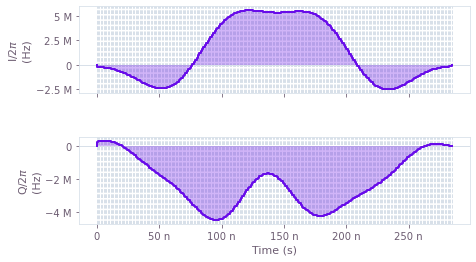

Square


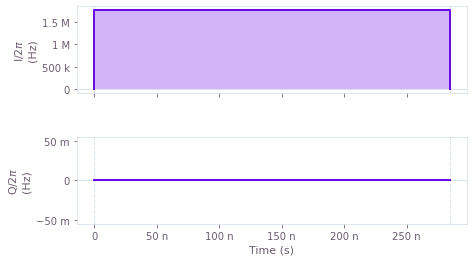

In [5]:
gate_schemes = {**robust_dephasing_controls, **{"Square": square_sequence}}

for scheme_name, gate in gate_schemes.items():
    print(scheme_name)
    plot_controls(plt.figure(), gate)
    plt.show()

The control plots represent the $I(t)$ and $Q(t)$ components of the control pulses for: Q-CTRL optimizations (top) and the primitive control (bottom). Note that the robust pulse obtained is mostly symmetrical. If desired, time-symmetrical pulses can be enforced within the optimization, as described in the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) User guide. 

### Simulated time evolution of the driven qubit

Another useful way to characterize the pulses is to use the Q-CTRL simulation tool to obtain the time evolution of the system. This way you can observe the effect of arbitrary pulses on the qubit dynamics and check if the pulses are performing the desired operation. The next two cells run the simulations, extract the results, and plot them.

In [6]:
# Q-CTRL simulations
simulated_bloch = {}
gate_times = {}
for scheme_name, control in gate_schemes.items():
    simulated_bloch[scheme_name], gate_times[scheme_name] = simulation_coherent(
        control, 100
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


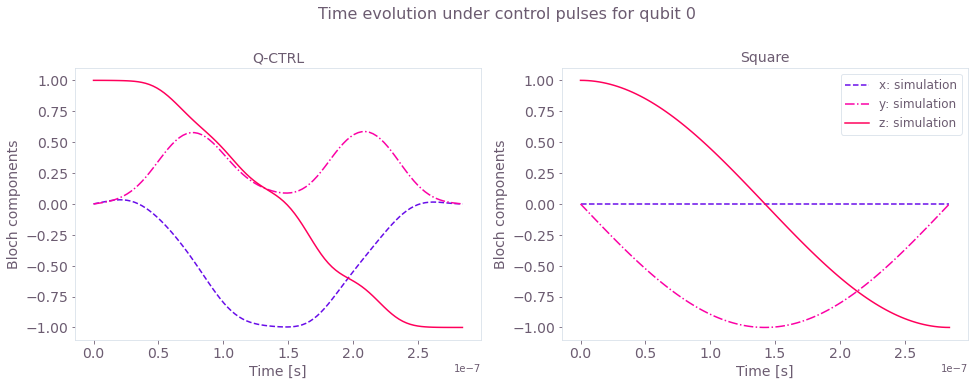

In [7]:
# Plot results
gs = gridspec.GridSpec(1, len(gate_schemes.keys()), hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle(
    "Time evolution under control pulses for qubit " + str(qubit), fontsize=16, y=1.05
)

for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    for meas_basis in bloch_basis:
        ax.plot(
            gate_times[scheme_name],
            simulated_bloch[scheme_name][meas_basis],
            ls=bloch_lines[meas_basis],
            label="%s: simulation" % (meas_basis),
        )
    ax.set_title(scheme_name, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Bloch components", fontsize=14)
    ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1), fontsize=12)

plt.show()

The simulated Bloch vector components $(x, y, z)$ of the state dynamics for the duration of the robust and primitive pulses.

### Robustness characterization with filter functions and quasi-static scan

Filter functions provide a useful way to determine the sensitivity of pulses to different time varying noise mechanisms. The next cells generate filter functions for the Q-CTRL robust pulses and the primitive square pulse under dephasing noise.

In [8]:
sample_count = 4096
frequencies = np.logspace(-2, np.log10(omega_max), 2000)
filter_functions = {}

for scheme_name, control in gate_schemes.items():
    durations = [segment["duration"] for segment in control["I"]]
    I_values = [segment["value"] for segment in control["I"]]
    Q_values = [segment["value"] for segment in control["Q"]]
    shift_I = qctrl.types.filter_function.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, I_values)
        ],
        operator=sigma_x / 2,
    )
    shift_Q = qctrl.types.filter_function.Shift(
        control=[
            qctrl.types.RealSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, Q_values)
        ],
        operator=sigma_y / 2,
    )
    dephasing_noise = qctrl.types.filter_function.Drift(
        noise=True,
        operator=sigma_z,
    )

    filter_function = qctrl.functions.calculate_filter_function(
        duration=np.sum(durations),
        frequencies=frequencies,
        sample_count=sample_count,
        shifts=[shift_I, shift_Q],
        drifts=[dephasing_noise],
    )

    filter_functions[scheme_name] = filter_function.samples

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has completed in 7s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has completed in 6s.


You can also verify the pulse robustness against quasi-static noises by comparing the optimized $\pi$-pulses with the primitive pulse while detuning the drive frequency from the qubit frequency: $\Delta = \omega_\text{drive}-\omega_\text{qubit}$. This is tantamount to an effective dephasing term in the Hamiltonian, the strength and effect of which may be measured by scanning the detuning $\Delta$. The scan is calculated in the cell below.

In [9]:
gate_infidelity = {}
scan_array = np.linspace(-np.pi * 1.0 * mega, np.pi * 1.0 * mega, 21)
gate_infidelity["dephasing"] = {
    scheme_name: get_detuning_scan(scan_array, control)
    for scheme_name, control in gate_schemes.items()
}

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_quasi_static_scan has completed in 4s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_quasi_static_scan has completed in 4s.


Here's a plot of the filter functions and the detuning scan.

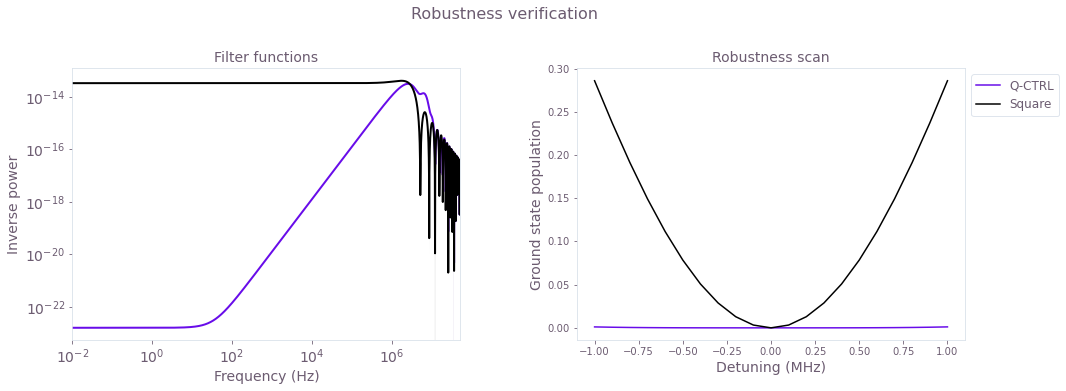

In [10]:
gs = gridspec.GridSpec(1, 2, wspace=0.3)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle("Robustness verification", fontsize=16, y=1.05)

ax = fig.add_subplot(gs[0])
ax.set_xlabel("Frequency (Hz)", fontsize=14)
ax.set_ylabel("Inverse power", fontsize=14)
ax.set_title("Filter functions", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim(np.min(frequencies), np.max(frequencies))
for scheme_name, _data in filter_functions.items():
    inverse_powers = np.array([_d.inverse_power for _d in _data])
    inverse_power_precisions = np.array([_d.inverse_power_uncertainty for _d in _data])

    plt.loglog(
        frequencies,
        inverse_powers,
        "-",
        linewidth=2,
        label=scheme_name,
        color=colors[scheme_name],
    )
    y_upper = inverse_powers + inverse_power_precisions
    y_lower = inverse_powers - inverse_power_precisions
    ax.fill_between(
        frequencies,
        y_lower,
        y_upper,
        hatch="||",
        alpha=0.35,
        facecolor="none",
        edgecolor=colors[scheme_name],
        linewidth=0.0,
    )

ax = fig.add_subplot(gs[1])
ax.set_title("Robustness scan", fontsize=14)
ax.set_ylabel("Ground state population", fontsize=14)
ax.set_xlabel("Detuning (MHz)", fontsize=14)
for name, infidelity in gate_infidelity["dephasing"].items():
    ax.plot(scan_array * 1e-6 / np.pi, infidelity, label=name, color=colors[name])
ax.legend(loc="best", bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

Left plot: Filter functions for the control pulses under dephasing noise. The hallmark of robustness is the significant drop of the filter function values at low frequencies. This feature is clearly demonstrated for the optimized Q-CTRL pulses. Right plot: Theoretical ground state population as a function of the detuning. The Q-CTRL solution shows flat behavior for a large range of detunings as compared to the primitive pulse, indicating robustness against dephasing.

### Experimental time evolution of the driven qubit

In this section you'll compare the implementation and performance of the pulses discussed previously. A good test to check that the Q-CTRL pulses are being implemented properly in the IBM hardware is to compare the theoretical with the experimental time evolution of the qubit state. The next cell executes the different steps to obtain such a comparison:
- Calibrate pulses for the specific IBM hardware, 
- Set up the schedules and run them on IBM-Q,
- Extract and plot the resulting dynamics.

Note that here you'll use Rabi rate calibration data obtained previously for the `ibmq_armonk` device. To learn how to calibrate devices yourself see the [Control hardware: pulse calibration](https://docs.q-ctrl.com/boulder-opal/application-notes/control-hardware-pulse-calibration) Application note.

In [11]:
# Calibrate pulses
rabi_calibration_exp_I = load_var(data_folder / "rabi_calibration_exp_I_demo")
pulse_amp_array = np.linspace(0.1, 1, 10)
pulse_amp_array = np.concatenate((-pulse_amp_array[::-1], pulse_amp_array))
f_amp_to_rabi = interpolate.interp1d(pulse_amp_array, rabi_calibration_exp_I)

amplitude_interpolated_list = np.linspace(-1, 1, 100)
rabi_interpolated_exp_I = f_amp_to_rabi(amplitude_interpolated_list)
f_rabi_to_amp = interpolate.interp1d(
    rabi_interpolated_exp_I, amplitude_interpolated_list
)

waveform = {}
for scheme_name, control in gate_schemes.items():
    I_values = [segment["value"] / 2 / np.pi for segment in control["I"]]
    Q_values = [segment["value"] / 2 / np.pi for segment in control["Q"]]
    if scheme_name == "Square":
        A_I_values = np.repeat(
            f_rabi_to_amp(I_values),
            segment_scale[scheme_name] * number_of_segments[scheme_name],
        )
        A_Q_values = np.repeat(
            f_rabi_to_amp(Q_values),
            segment_scale[scheme_name] * number_of_segments[scheme_name],
        )
    else:
        A_I_values = np.repeat(f_rabi_to_amp(I_values), segment_scale[scheme_name])
        A_Q_values = np.repeat(f_rabi_to_amp(Q_values), segment_scale[scheme_name])
    waveform[scheme_name] = A_I_values + 1j * A_Q_values


# Create IBM schedules
ibm_evolution_times = {}
times_int = {}
pulse_evolution_program = {}
time_min = 64
time_step = 64

for scheme_name in gate_schemes.keys():
    time_max = int(segment_scale[scheme_name] * number_of_segments[scheme_name])
    times_int[scheme_name] = np.arange(time_min, time_max + time_step, time_step)
    ibm_evolution_times[scheme_name] = times_int[scheme_name] * dt


if use_IBM == True:
    # Refresh backend
    backend.properties(refresh=True)
    qubit_frequency_updated = backend.properties().qubit_property(qubit, "frequency")[0]

    for scheme_name in gate_schemes.keys():
        evolution_schedules = []
        for meas_basis in bloch_basis:
            for time_idx in times_int[scheme_name]:
                schedule = pulse.Schedule(
                    name="Basis_%s_duration_%d" % (meas_basis, time_idx)
                )
                schedule += Play(Waveform(waveform[scheme_name][:time_idx]), drive_chan)
                if meas_basis == "x":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "y":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "z":
                    schedule += measure_schedule << schedule.duration
                evolution_schedules.append(schedule)

        pulse_evolution_program[scheme_name] = assemble(
            evolution_schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}]
            * len(times_int[scheme_name])
            * 3,
        )

    if use_saved_data == False:
        # Run the jobs
        evolution_exp_results = {}
        for scheme_name in gate_schemes.keys():
            job = backend.run(pulse_evolution_program[scheme_name])
            job_monitor(job)
            evolution_exp_results[scheme_name] = job.result(timeout=120)

        # Extract results
        evolution_results_ibm = {}
        for scheme_name in gate_schemes.keys():
            evolution_basis = {}
            for meas_basis in bloch_basis:
                evolution_exp_data = np.zeros(len(times_int[scheme_name]))
                for idx, time_idx in enumerate(times_int[scheme_name]):
                    counts = evolution_exp_results[scheme_name].get_counts(
                        "Basis_%s_duration_%d" % (meas_basis, time_idx)
                    )
                    excited_pop = 0
                    for bits, count in counts.items():
                        excited_pop += count if bits[::-1][qubit] == "1" else 0
                    evolution_exp_data[idx] = excited_pop / num_shots_per_point
                evolution_basis[meas_basis] = evolution_exp_data
            evolution_results_ibm[scheme_name] = evolution_basis

        filename = data_folder / ("bloch_vectors_dephasing_" + timestr)
        save_var(filename, evolution_results_ibm)
    else:
        filename = data_folder / "bloch_vectors_dephasing_demo"
        evolution_results_ibm = load_var(filename)

else:
    filename = data_folder / "bloch_vectors_dephasing_demo"
    evolution_results_ibm = load_var(filename)

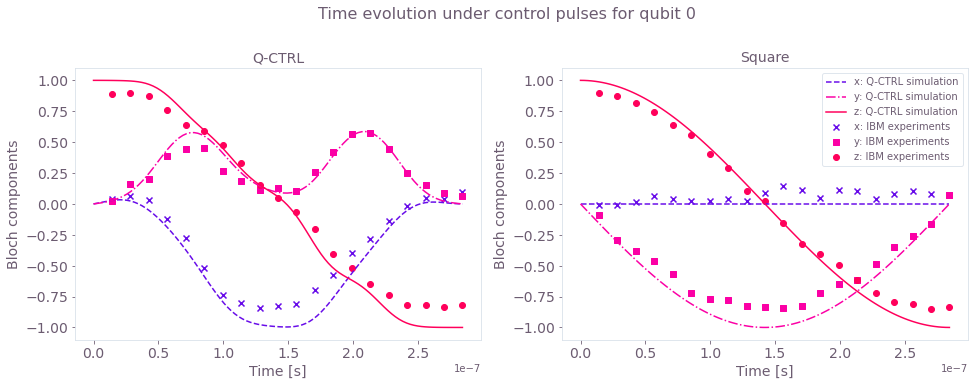

In [12]:
# Plot results
gs = gridspec.GridSpec(1, len(gate_schemes.keys()), hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle(
    "Time evolution under control pulses for qubit " + str(qubit), fontsize=16, y=1.05
)

for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    for meas_basis in bloch_basis:
        ax.plot(
            gate_times[scheme_name],
            simulated_bloch[scheme_name][meas_basis],
            ls=bloch_lines[meas_basis],
            label="%s: Q-CTRL simulation" % (meas_basis),
        )
        ax.scatter(
            ibm_evolution_times[scheme_name],
            1 - 2 * evolution_results_ibm[scheme_name][meas_basis],
            label="%s: IBM experiments" % (meas_basis),
            marker=bloch_markers[meas_basis],
        )
    ax.set_title(scheme_name, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Bloch components", fontsize=14)
    ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1))
plt.show()

Comparison between the Bloch vector components (x, y, z) for the IBM experiments (symbols) and numerical simulation (lines). The smooth and band-limited Q-CTRL pulse [waveform](#Creating-dephasing-robust-pulses) successfully implements the desired gate on the IBM hardware.

### Experimental robustness verification with a quasi-static scan

To demonstrate the pulse robustness, you'll perform the experimental detuning scan, similar to what was done for the theoretical controls. As an extra comparison case, added to the scan here is the default X-gate for this IBM backend. The steps to achieve this are combined in the next execution cell, as follows:
- Define detuning sweep interval,
- Create schedules and run jobs on IBM-Q,
- Extract results and produce robustness plot.

In [13]:
scheme_names.append("IBM default X-gate")
# Define detuning sweep interval
detuning_array = np.linspace(
    qubit_frequency_updated - 1e6, qubit_frequency_updated + 1e6, 21
)
number_of_runs = 20
num_shots_per_point = 512

# Create schedules and run jobs
if use_IBM == True and use_saved_data == False:
    drive_frequencies = [{drive_chan: freq} for freq in detuning_array]

    pi_experiment_results = {}
    for run in range(number_of_runs):
        for scheme_name in scheme_names:
            # Default IBM X-gate
            if scheme_name == "IBM default X-gate":
                pi_schedule = pulse.Schedule(name="IBM default X-gate")
                pi_schedule |= inst_sched_map.get(
                    "u3", [qubit], P0=np.pi, P1=0.0, P2=np.pi
                )
            else:
                pi_schedule = pulse.Schedule(name=scheme_name)
                pi_schedule += Play(Waveform(waveform[scheme_name]), drive_chan)
            pi_schedule += measure_schedule << pi_schedule.duration

            pi_experiment_ibm = assemble(
                pi_schedule,
                backend=backend,
                meas_level=2,
                meas_return="single",
                shots=num_shots_per_point,
                schedule_los=drive_frequencies,
            )

            job = backend.run(pi_experiment_ibm)
            print(job.job_id())
            job_monitor(job)
            pi_experiment_results[scheme_name + str(run)] = job.result(timeout=120)

    # Extract results
    detuning_sweep_results = {}
    for scheme_name in scheme_names:
        qctrl_sweep_values = np.zeros((number_of_runs, len(detuning_array)))
        for run in range(number_of_runs):
            i = 0
            for result in pi_experiment_results[scheme_name + str(run)].results:
                counts = result.data.counts["0x1"]
                excited_pop = counts / num_shots_per_point
                qctrl_sweep_values[run][i] = 1 - excited_pop
                i = i + 1
        detuning_sweep_results[scheme_name] = qctrl_sweep_values
    filename = data_folder / ("detuning_sweep_results_" + timestr)
    save_var(filename, detuning_sweep_results)

else:
    filename = data_folder / "detuning_sweep_results_demo"
    detuning_sweep_results = load_var(filename)

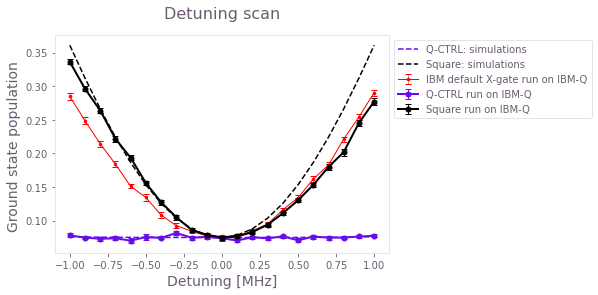

In [14]:
# Robustness plot
fig, ax = plt.subplots()
for scheme_name, probability in detuning_sweep_results.items():
    if scheme_name == "Q-CTRL" or scheme_name == "Square":
        lw = 2
        ms = 5
        el = 1
    else:
        lw = 1
        ms = 2.5
        el = 0.5
    ax.errorbar(
        detuning_array / mega - qubit_frequency_updated / mega,
        np.mean(probability, axis=0),
        yerr=np.std(probability, axis=0)
        / np.sqrt(len(detuning_sweep_results[scheme_name])),
        fmt="-o",
        linewidth=lw,
        markersize=ms,
        elinewidth=el,
        capsize=3,
        label=scheme_name + " run on IBM-Q",
        color=colors[scheme_name],
    )
    if scheme_name != "IBM default X-gate":
        plt.plot(
            detuning_array / mega - qubit_frequency_updated / mega,
            gate_infidelity["dephasing"][scheme_name] + 0.075,
            linestyle="dashed",
            label=scheme_name + str(": simulations"),
            color=colors[scheme_name],
        )

plt.xlabel("Detuning [MHz]", fontsize=14)
plt.ylabel("Ground state population ", fontsize=14)
plt.title("Detuning scan", fontsize=16, y=1.05)
plt.legend(loc="best", bbox_to_anchor=(1, 1.0))
plt.show()

Experimental (symbols) and simulated (lines) ground state populations as a function of the detuning. The `Q-CTRL` control solution is mostly flat across the detuning scan, showing its robustness against dephasing noise as compared to the primitive square pulse as well as the default IBM X-gate. The theoretical curves have been shifted up by $0.075$ to account for measurement errors in the experimental data.

## Other noise sources: Q-CTRL pulse robustness against control error

Besides robustness to dephasing, you can also use BOULDER OPAL to design solutions that are robust against errors in the control amplitudes. The workflow is exactly as in the dephasing case:
- Initialize Q-CTRL optimization parameters,
- Run optimization and extract results,
- Characterize robustness using filter functions,
- Calibrate and implement pulses,
- Verify robustness with amplitude scan.

### Creating pulses robust to control amplitude errors

The next cell contains all Q-CTRL commands to generate pulses for the control scenario defined previously. The only difference to the dephasing case is that the `noise_operators` are now time-varying terms of the control Hamiltonian.

In [15]:
number_of_segments = 256
number_of_optimization_variables = 64
segment_scale = 10
duration_int = number_of_segments * segment_scale
duration = duration_int * dt
cutoff_frequency = omega_max * 2.0
scheme_names = []

if use_saved_data == False:
    robust_amplitude_controls = {}

    with qctrl.create_graph() as graph:

        # Create I & Q variables
        I_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables,
            lower_bound=-I_max,
            upper_bound=I_max,
        )
        Q_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_optimization_variables,
            lower_bound=-Q_max,
            upper_bound=Q_max,
        )

        # Anchor ends to zero with amplitude rise/fall envelope
        time_points = np.linspace(-1.0, 1.0, number_of_optimization_variables + 2)[1:-1]
        envelope_function = 1.0 - np.abs(time_points)
        I_values = I_values * envelope_function
        Q_values = Q_values * envelope_function

        # Create I & Q signals
        I_signal = qctrl.operations.pwc_signal(values=I_values, duration=duration)
        Q_signal = qctrl.operations.pwc_signal(values=Q_values, duration=duration)

        # Apply the sinc filter
        sinc_filter = qctrl.operations.sinc_integral_function(cutoff_frequency)

        I_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=I_signal, kernel_integral=sinc_filter
        )
        Q_signal_filtered = qctrl.operations.convolve_pwc(
            pwc=Q_signal, kernel_integral=sinc_filter
        )

        # Re-discretize signal
        I_signal = qctrl.operations.discretize_stf(
            stf=I_signal_filtered,
            duration=duration,
            segments_count=number_of_segments,
            name="I",
        )
        Q_signal = qctrl.operations.discretize_stf(
            stf=Q_signal_filtered,
            duration=duration,
            segments_count=number_of_segments,
            name="Q",
        )

        # Create Hamiltonian control terms
        I_term = qctrl.operations.pwc_operator(signal=I_signal, operator=sigma_x / 2.0)

        Q_term = qctrl.operations.pwc_operator(signal=Q_signal, operator=sigma_y / 2.0)

        control_hamiltonian = qctrl.operations.pwc_sum([I_term, Q_term])

        # Create dephasing noise term
        amplitude = control_hamiltonian

        # Create infidelity
        infidelity = qctrl.operations.infidelity_pwc(
            hamiltonian=control_hamiltonian,
            target_operator=qctrl.operations.target(X_gate),
            noise_operators=[amplitude],
            name="infidelity",
        )

    # Calculate optimization
    graph = qctrl.functions.calculate_optimization(
        cost_node_name="infidelity",
        output_node_names=["I", "Q"],
        graph=graph,
    )

    print(f"Cost: {graph.cost}")

    robust_amplitude_controls["Q-CTRL"] = graph.output

    filename = data_folder / ("robust_amplitude_controls_" + timestr)
    save_var(filename, robust_amplitude_controls)
else:
    filename = data_folder / "robust_amplitude_controls_demo"
    robust_amplitude_controls = load_var(filename)
scheme_names.append("Q-CTRL")

In [16]:
# Create square pulse
square_pulse_durations = np.array([duration])
square_pulse_values_control = np.array([rabi_rotation / duration])
square_sequence = {
    "I": [
        {"duration": d, "value": v}
        for d, v in zip(square_pulse_durations, square_pulse_values_control)
    ],
    "Q": [
        {"duration": d, "value": v}
        for d, v in zip(square_pulse_durations, np.zeros([number_of_segments]))
    ],
}
scheme_names.append("Square")
# Combine all pulses into a single dictionary
gate_schemes = {**robust_amplitude_controls, **{"Square": square_sequence}}

# Add IBM default X-gate
scheme_names.append("IBM default X-gate")

Q-CTRL


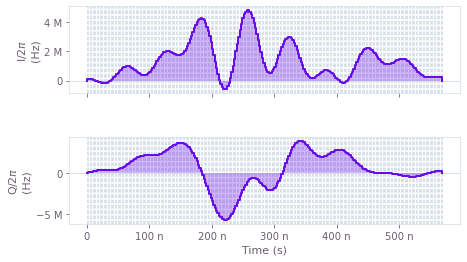

Square


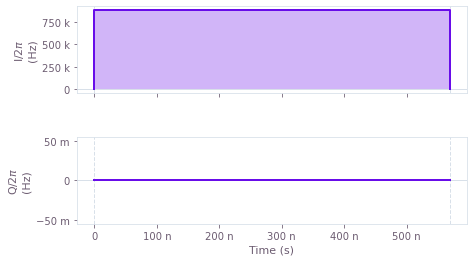

In [17]:
for scheme_name, gate in gate_schemes.items():
    print(scheme_name)
    plot_controls(plt.figure(), gate)
    plt.show()

$I(t)$ and $Q(t)$ components of the control pulses for the optimized (top) and primitive (bottom) controls. Note that the duration of the pulses has increased. This is to enable you to test the robustness of the pulses later, by scanning over a large range of control amplitude errors. Therefore using longer pulses (and lower Rabi rates) will help you to always stay within the maximum Rabi rate bounds given by the backend.

### Time evolution of the driven qubit: simulations and experiment

As for the amplitude robust pulses, you'll calibrate the control-error-robust pulses using the interpolation obtained previously and run them on the IBM machine to compare the theoretical and experimental time evolution of the qubit state under no added noise. The cell below combines the following steps:
- Pulse calibration,
- Set up IBM schedules,
- Run jobs on IBM-Q and extract results,
- Run Q-CTRL simulations,
- Plot results.

In [18]:
# Pulse calibration
waveform = {}
for scheme_name, control in gate_schemes.items():
    I_values = [segment["value"] / 2 / np.pi for segment in control["I"]]
    Q_values = [segment["value"] / 2 / np.pi for segment in control["Q"]]
    if scheme_name == "Square":
        A_I_values = np.repeat(
            f_rabi_to_amp(I_values), segment_scale * number_of_segments
        )
        A_Q_values = np.repeat(
            f_rabi_to_amp(Q_values), segment_scale * number_of_segments
        )
    else:
        A_I_values = np.repeat(f_rabi_to_amp(I_values), segment_scale)
        A_Q_values = np.repeat(f_rabi_to_amp(Q_values), segment_scale)
    waveform[scheme_name] = A_I_values + 1j * A_Q_values

# Create IBM schedules
time_min = 64
time_max = duration_int
time_step = 128
num_shots_per_point = 2048
times_int = np.arange(time_min, time_max + time_step, time_step)
ibm_evolution_times = times_int * dt
num_time_points = len(times_int)

if use_IBM == True:
    for scheme_name in gate_schemes.keys():
        evolution_schedules = []
        for meas_basis in bloch_basis:
            for time_idx in times_int:
                schedule = pulse.Schedule(
                    name="Basis_%s_duration_%d" % (meas_basis, time_idx)
                )
                schedule += Play(Waveform(waveform[scheme_name][:time_idx]), drive_chan)
                if meas_basis == "x":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "y":
                    schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
                    schedule += measure_schedule << schedule.duration
                if meas_basis == "z":
                    schedule += measure_schedule << schedule.duration
                evolution_schedules.append(schedule)

        pulse_evolution_program[scheme_name] = assemble(
            evolution_schedules,
            backend=backend,
            meas_level=2,
            meas_return="single",
            shots=num_shots_per_point,
            schedule_los=[{drive_chan: qubit_frequency_updated}] * len(times_int) * 3,
        )

    if use_saved_data == False:
        evolution_exp_results = {}
        for scheme_name in gate_schemes.keys():
            job = backend.run(pulse_evolution_program[scheme_name])
            job_monitor(job)
            evolution_exp_results[scheme_name] = job.result(timeout=120)

        # Extract results
        evolution_results_ibm = {}
        for scheme_name in gate_schemes.keys():
            evolution_basis = {}
            for meas_basis in bloch_basis:
                evolution_exp_data = np.zeros(len(times_int))
                for idx, time_idx in enumerate(times_int):
                    counts = evolution_exp_results[scheme_name].get_counts(
                        "Basis_%s_duration_%d" % (meas_basis, time_idx)
                    )
                    excited_pop = 0
                    for bits, count in counts.items():
                        excited_pop += count if bits[::-1][qubit] == "1" else 0
                    evolution_exp_data[idx] = excited_pop / num_shots_per_point
                evolution_basis[meas_basis] = evolution_exp_data
            evolution_results_ibm[scheme_name] = evolution_basis

        filename = data_folder / ("bloch_vectors_amplitude_" + timestr)
        save_var(filename, evolution_results_ibm)
    else:
        filename = data_folder / "bloch_vectors_amplitude_demo"
        evolution_results_ibm = load_var(filename)
else:
    filename = data_folder / "bloch_vectors_amplitude_demo"
    evolution_results_ibm = load_var(filename)

In [19]:
# Q-CTRL simulations
simulated_bloch = {}
gate_times = {}
for scheme_name, control in gate_schemes.items():
    simulated_bloch[scheme_name], gate_times[scheme_name] = simulation_coherent(
        control, 100
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


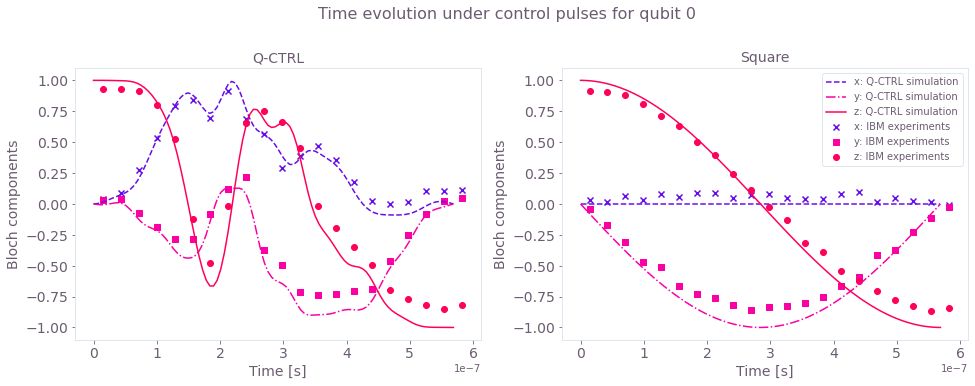

In [20]:
# Plot results
gs = gridspec.GridSpec(1, len(gate_schemes.keys()), hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle(
    "Time evolution under control pulses for qubit " + str(qubit), fontsize=16, y=1.05
)

for idx, scheme_name in enumerate(gate_schemes.keys()):
    ax = fig.add_subplot(gs[idx])
    for meas_basis in bloch_basis:
        ax.plot(
            gate_times[scheme_name],
            simulated_bloch[scheme_name][meas_basis],
            ls=bloch_lines[meas_basis],
            label="%s: Q-CTRL simulation" % (meas_basis),
        )
        ax.scatter(
            ibm_evolution_times,
            1 - 2 * evolution_results_ibm[scheme_name][meas_basis],
            label="%s: IBM experiments" % (meas_basis),
            marker=bloch_markers[meas_basis],
        )
    ax.set_title(scheme_name, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Bloch components", fontsize=14)
    ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1))

plt.show()

Time evolution of the Bloch vector components (x, y, z) for simulations (lines) and experimental runs (symbols) under the [control-robust pulses](#Creating-pulses-robust-to-control-amplitude-errors).

### Experimental robustness verification with a quasi-static scan and filter functions

You'll again assess the sensitivity of the pulses to the noise using filter functions and static scans. The only difference here is the change in the noise process, which is achieved by replacing the dephasing term by noise on the controls. The filter functions calculated in the cell below use noise in the $I$ and $Q$ components of the controls.

In [21]:
sample_count = 4096
frequencies = np.logspace(-2, np.log10(omega_max), 2000)
filter_functions = {}

for scheme_name, control in gate_schemes.items():
    durations = [segment["duration"] for segment in control["I"]]
    I_values = np.array([segment["value"] for segment in control["I"]])
    Q_values = np.array([segment["value"] for segment in control["Q"]])
    phasors = I_values + Q_values * 1j

    drive = qctrl.types.filter_function.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(duration=duration, value=value)
            for duration, value in zip(durations, phasors)
        ],
        operator=sigma_p / 2,
        noise=True,
    )

    filter_function = qctrl.functions.calculate_filter_function(
        duration=np.sum(durations),
        frequencies=frequencies,
        sample_count=sample_count,
        drives=[drive],
    )

    filter_functions[scheme_name] = filter_function.samples

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has completed in 7s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has completed in 7s.


You can also demonstrate robustness by performing a control error scan, both numerically and experimentally. The steps follow the same structure as in the dephasing case and are combined in the next cell:
- Define control error range,
- Create schedules and run them on IBM-Q,
- Create Q-CTRL theoretical control error scan.

In [22]:
scheme_names = ["Q-CTRL", "Square", "IBM default X-gate"]
# Define control amplitude error range
amp_error = 0.25
amp_scalings = np.linspace(1 - amp_error, amp_error + 1, 21)

# Define schedules and run jobs
if use_IBM == True and use_saved_data == False:
    IBM_default_X_gate_schedule = inst_sched_map.get(
        "u3", [qubit], P0=np.pi, P1=0.0, P2=np.pi
    )
    pi_experiment_results = {}
    for run in range(number_of_runs):
        for scheme_name in scheme_names:
            pi_schedule = []
            for amp_scaling in amp_scalings:
                if scheme_name == "IBM default X-gate":
                    this_schedule = pulse.Schedule(name=scheme_name)
                    for idx, inst in enumerate(
                        IBM_default_X_gate_schedule.instructions
                    ):
                        if inst[1].name is None:
                            this_schedule |= pulse.Schedule(inst)
                        else:  # if "X90" in inst[1].name:
                            Ival = np.real(inst[1].instructions[0][1].pulse.samples)
                            Qval = np.imag(inst[1].instructions[0][1].pulse.samples)
                            phasors = Ival + 1j * Qval
                            this_schedule |= (
                                Play(
                                    Waveform(phasors * amp_scaling), inst[1].channels[0]
                                )
                                << this_schedule.duration
                            )
                    this_schedule += measure_schedule << this_schedule.duration
                    pi_schedule.append(this_schedule)
                else:
                    this_schedule = pulse.Schedule(name=scheme_name)
                    this_schedule += (
                        Play(Waveform(waveform[scheme_name] * amp_scaling), drive_chan)
                        << 1
                    )
                    this_schedule += measure_schedule << duration_int
                    pi_schedule.append(this_schedule)

            num_shots_per_point = 512

            pi_experiment_ibm = assemble(
                pi_schedule,
                backend=backend,
                meas_level=2,
                meas_return="single",
                shots=num_shots_per_point,
                schedule_los=[{drive_chan: qubit_frequency_updated}]
                * len(amp_scalings),
            )
            job = backend.run(pi_experiment_ibm)
            print(job.job_id())
            job_monitor(job)
            pi_experiment_results[scheme_name + str(run)] = job.result(timeout=120)

    # Extracting results
    amplitude_sweep_results = {}
    for scheme_name in scheme_names:
        qctrl_sweep_values = np.zeros((number_of_runs, len(amp_scalings)))
        for run in range(number_of_runs):
            i = 0
            for result in pi_experiment_results[scheme_name + str(run)].results:
                counts = result.data.counts["0x1"]
                excited_pop = counts / num_shots_per_point
                qctrl_sweep_values[run][i] = 1 - excited_pop
                i = i + 1
        amplitude_sweep_results[scheme_name] = qctrl_sweep_values
    filename = data_folder / ("amplitude_sweep_results_" + timestr)
    save_var(filename, amplitude_sweep_results)
else:
    filename = data_folder / "amplitude_sweep_results_demo"
    amplitude_sweep_results = load_var(filename)

In [23]:
# Q-CTRL control amplitude scan
gate_infidelity = {}
amplitude_array = np.linspace(-0.25, 0.25, 21)
gate_infidelity["amplitude"] = {
    scheme_name: get_amplitude_scan(amplitude_array, control)
    for scheme_name, control in gate_schemes.items()
}

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_quasi_static_scan has completed in 4s.


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_quasi_static_scan has completed in 4s.


Next, plot the numerical filter functions and the control error scan.

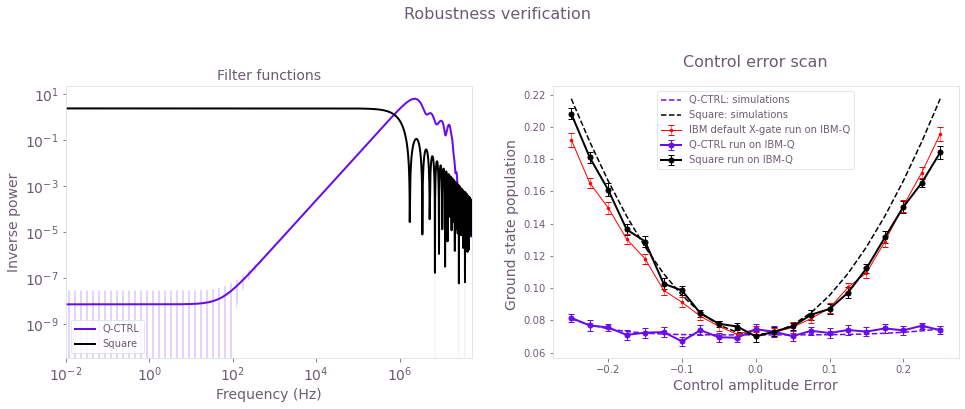

In [24]:
gs = gridspec.GridSpec(1, 2, wspace=0.2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle("Robustness verification", fontsize=16, y=1.1)

ax = fig.add_subplot(gs[0])
ax.set_xlabel("Frequency (Hz)", fontsize=14)
ax.set_ylabel("Inverse power", fontsize=14)
ax.set_title("Filter functions", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim(np.min(frequencies), np.max(frequencies))

for scheme_name, _data in filter_functions.items():
    inverse_powers = np.array([_d.inverse_power for _d in _data])
    inverse_power_precisions = np.array([_d.inverse_power_uncertainty for _d in _data])

    plt.loglog(
        frequencies,
        inverse_powers,
        "-",
        linewidth=2,
        label=scheme_name,
        color=colors[scheme_name],
    )
    y_upper = inverse_powers + inverse_power_precisions
    y_lower = inverse_powers - inverse_power_precisions
    ax.fill_between(
        frequencies,
        y_lower,
        y_upper,
        hatch="||",
        alpha=0.35,
        facecolor="none",
        edgecolor=colors[scheme_name],
        linewidth=0.0,
    )
ax.legend(loc="best")

ax = fig.add_subplot(gs[1])
ax.set_title("Robustness scan", fontsize=14)
ax.set_ylabel("Ground state population", fontsize=14)
ax.set_xlabel("Control amplitude error", fontsize=14)
for scheme_name, probability in amplitude_sweep_results.items():
    if scheme_name == "Q-CTRL" or scheme_name == "Square":
        lw = 2
        ms = 5
        el = 1
    else:
        lw = 1
        ms = 2.5
        el = 0.5
    ax.errorbar(
        amp_scalings - 1,
        np.mean(probability, axis=0),
        yerr=np.std(probability, axis=0)
        / np.sqrt(len(amplitude_sweep_results[scheme_name])),
        fmt="-o",
        linewidth=lw,
        markersize=ms,
        elinewidth=el,
        capsize=3,
        label=scheme_name + " run on IBM-Q",
        color=colors[scheme_name],
    )
    if scheme_name != "IBM default X-gate":
        plt.plot(
            amp_scalings - 1,
            gate_infidelity["amplitude"][scheme_name] + 0.071,
            linestyle="dashed",
            label=scheme_name + str(": simulations"),
            color=colors[scheme_name],
        )


plt.xlabel("Control amplitude Error", fontsize=14)
plt.ylabel("Ground state population ", fontsize=14)
plt.title("Control error scan", fontsize=16, y=1.05)
ax.legend(loc="best")
plt.show()

Left plot: Filter functions for the control pulses under control noise in the $I$ component. Again, robustness is clearly demonstrated for the optimized `Q-CTRL` pulses. Right plot: Experimental (symbols) and simulated (lines) ground state populations as a function of the error in the control amplitude (note that the control amplitudes vary between -1 and 1). The `Q-CTRL` control solution is robust, with a flat response for a large range of control errors as compared to the primitive pulse. The theoretical curves have been shifted up by $0.071$ to account for measurement errors in the experimental data.